# UNet implementation using pytorch for MRI segmentation
- unet: https://github.com/mateuszbuda/brain-segmentation-pytorch
- pytorch FLOP counter: https://github.com/sovrasov/flops-counter.pytorch

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import torch 
import torchvision.models as models
import matplotlib.pyplot as plt
from pypapi import events, papi_high as high 
from ptflops import get_model_complexity_info

from pyJoules.energy_meter import measure_energy
from pyJoules.handler.csv_handler import CSVHandler
from pyJoules.handler.pandas_handler import PandasHandler


### Paths

In [2]:
project_dir = '../'
data_dir = '{}data/'.format(project_dir)
results_dir = '{}results/'.format(project_dir)

## Measure FLOPs

### Pre-trained example

In [3]:
init_features = 32
input_size = 256 #i.e. 256x256
n_channels = 3

model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=n_channels, out_channels=1, init_features=init_features, pretrained=True)
    
macs, params = get_model_complexity_info(model, (n_channels, input_size, input_size), as_strings=True,
                                           print_per_layer_stat=False, verbose=False)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Using cache found in /home/nikhil/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master
Computational complexity:       13.74 GMac
Number of parameters:           7.76 M  


In [4]:

resnet18 = models.resnet18(pretrained=True)
alexnet = models.alexnet(pretrained=True)
squeezenet = models.squeezenet1_0(pretrained=True)
inception = models.inception_v3(pretrained=True)
googlenet = models.googlenet(pretrained=True)
mobilenet = models.mobilenet_v2(pretrained=True)
fcn_resnet50 = models.segmentation.fcn_resnet50(pretrained=True)
fcn_resnet101 = models.segmentation.fcn_resnet101(pretrained=True)
unet_small = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
                        in_channels=3, out_channels=1, init_features=32, pretrained=False)
unet_med = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
                        in_channels=3, out_channels=1, init_features=128, pretrained=False)

Using cache found in /home/nikhil/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master
Using cache found in /home/nikhil/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [8]:
model_dict = { 'mobilenet':mobilenet, 'squeezenet':squeezenet, 'alexnet':alexnet, 'googlenet':googlenet, 'resnet18':resnet18,
'fcn_resnet50':fcn_resnet50, 'fcn_resnet101':fcn_resnet101, 'unet_small':unet_small,'unet_mid':unet_med}

input_size_list = [64, 256]

In [32]:
init_features = 'n/a'
n_channels = 3

FLOP_df = pd.DataFrame(columns=['model','input_size','init_features','n_channels','FLOPs','FLOP_unit','n_parameters', 'param_unit']) 
i = 0

for name, model in model_dict.items():
    for input_size in input_size_list:
        macs, params = get_model_complexity_info(model, (n_channels, input_size, input_size), as_strings=True,
                                                            print_per_layer_stat=False, verbose=False)

        if name == 'unet_small':
            init_features = 32
        else:
            init_features = 128

        FLOP_df.loc[i] = [name,input_size,init_features,n_channels] + macs.split(' ') + params.split(' ')
        i = i + 1

FLOP_df.head()

ng: variables __flops__ or __params__ are already defined for the moduleBatchNorm2d ptflops can affect your code!


,model,input_size,init_features,n_channels,FLOPs,FLOP_unit,n_parameters,param_unit
0,mobilenet,64,128,3,0.03,GMac,3.5,M
1,mobilenet,256,128,3,0.42,GMac,3.5,M
2,squeezenet,64,128,3,0.05,GMac,1.25,M
3,squeezenet,256,128,3,1.1,GMac,1.25,M
4,alexnet,64,128,3,0.1,GMac,61.1,M


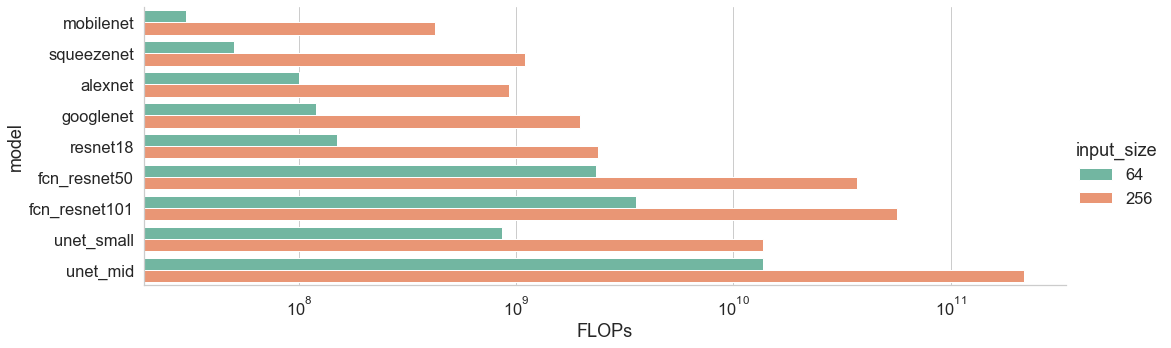

In [33]:
plot_df = FLOP_df.copy()
plot_df['FLOPs'] = 1e9*plot_df['FLOPs'].astype(np.float) 
plot_df['n_parameters'] = 1e6*plot_df['n_parameters'].astype(np.float) 

sns.set(font_scale = 1.5)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y='model',x='FLOPs', hue='input_size', kind='bar', data=plot_df, ax=ax1, palette='Set2',aspect=3)

    g.set(xscale="log") 
    

## Measure energy

In [37]:
def measure_inference_energy(x, model, handler):
    @measure_energy(handler=handler)
    def predict(x, model):
        x_tensor = torch.from_numpy(x).float()
        model.eval()
        y = model(torch.tensor(x_tensor))
        return y
        
    predict(x,model)


In [38]:
func_name = 'predict'
joules_csv = '{}{}_joules_all_models.csv'.format(results_dir, func_name)

print('Saving joules results here: {}'.format(joules_csv))
csv_handler = CSVHandler(joules_csv)

model_names = []
for name, model in model_dict.items():
    for input_size in input_size_list:
        model_names.append(name)
        x = np.random.random((1, n_channels, input_size, input_size))
        measure_inference_energy(x, model, csv_handler)
        
csv_handler.save_data()

Saving joules results here: ../results/predict_joules_all_models.csv


In [39]:
joules_df  = pd.read_csv(joules_csv,sep=';')
joules_df['model'] = model_names
joules_df['input_size']= np.tile(input_size_list,len(model_dict))

joules_df.head()

,timestamp,tag,duration,package_0,dram_0,core_0,uncore_0,model,input_size
0,1.611447e+09,predict,0.025677,367552.0,63659.0,245666.0,48950.0,mobilenet,64
1,1.611447e+09,predict,0.061232,1033200.0,158080.0,560606.0,276916.0,mobilenet,256
2,1.611447e+09,predict,0.012247,238586.0,27222.0,120728.0,83984.0,squeezenet,64
3,1.611447e+09,predict,0.060105,1303524.0,146240.0,818845.0,331420.0,squeezenet,256
4,1.611447e+09,predict,0.020577,334167.0,65612.0,207580.0,75683.0,alexnet,64


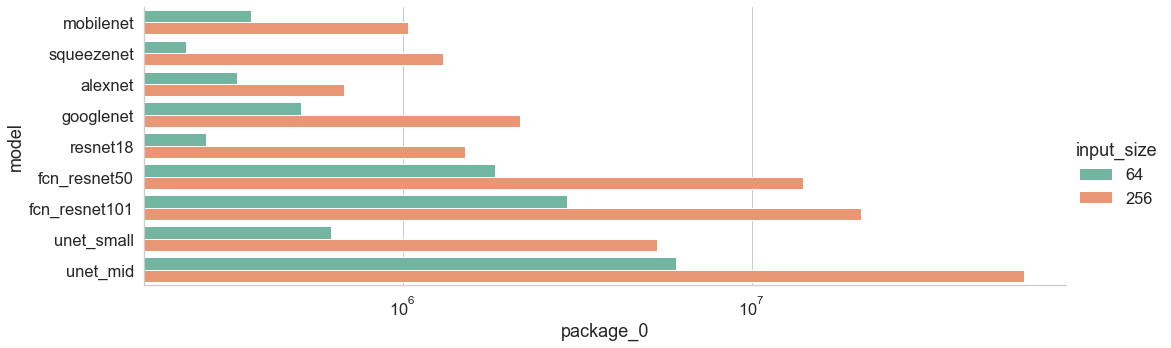

In [40]:
plot_df = joules_df.copy()
sns.set(font_scale = 1.5)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y='model',x='package_0', hue='input_size', kind='bar', data=plot_df, palette='Set2',aspect=3)

    g.set(xscale="log")

### Joint plot of FLOPs and Energy

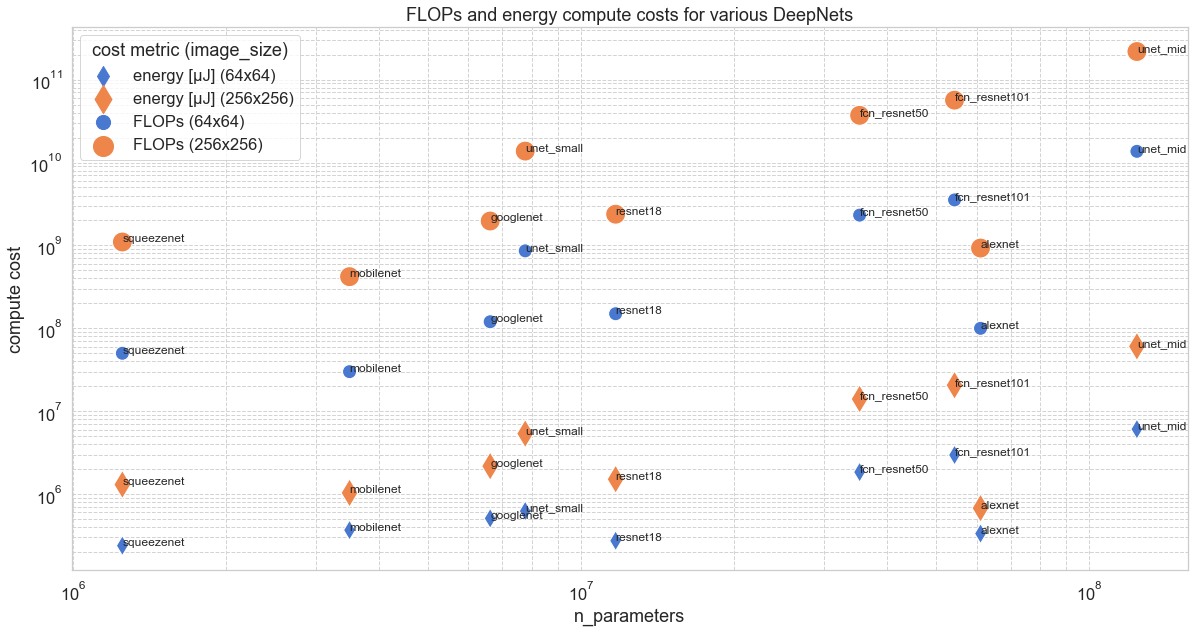

In [98]:
plot_df = pd.merge(FLOP_df, joules_df, on=['model','input_size'])
plot_df['FLOPs'] = 1e9*plot_df['FLOPs'].astype(np.float) 
plot_df['n_parameters'] = 1e6*plot_df['n_parameters'].astype(np.float) 

sns.set(font_scale = 1.5)
palette = sns.color_palette("muted", 2) #sns.color_palette("husl", 2)
with sns.axes_style("whitegrid"):
    fig, ax1 = plt.subplots(figsize=(20,10),sharex=True,sharey=True)
    g = sns.scatterplot(x='n_parameters',y='package_0', hue='input_size', size='input_size', sizes=[200,400], style='input_size', markers=['d','d'], data=plot_df, palette=palette,ax=ax1)
    g = sns.scatterplot(x='n_parameters',y='FLOPs', hue='input_size', size='input_size', sizes=[200,400], data=plot_df, palette=palette,ax=ax1)

    g.set(xscale="log",yscale='log')
    g.grid(True,which="both",ls="--",c='lightgray')  
    plt.ylabel('compute cost') #'FLOP count -- energy (μJ)
    plt.title('FLOPs and energy compute costs for various DeepNets')
    
    new_labels = ['energy [μJ] (64x64)','energy [μJ] (256x256)','FLOPs (64x64)','FLOPs (256x256)']
    leg = ax1.get_legend()
    leg.set_title('cost metric (image_size)')
    for t, l in zip(leg.texts, new_labels): t.set_text(l)

    def label_point(x, y, val, ax, x_shift=0.1, y_shift=0.1):
        a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
        for i, point in a.iterrows():
            ax.text(point['x']+x_shift, point['y']+y_shift, str(point['val']), fontsize=12)

    label_point(plot_df['n_parameters'], plot_df['package_0'], plot_df['model'], plt.gca())
    label_point(plot_df['n_parameters'], plot_df['FLOPs'], plot_df['model'], plt.gca())

## Unet architecture variations (with no-pretrained models)
- input_size
- init_features 

#### FLOPs

In [18]:
model_name = 'unet'
input_size_list = [64, 256] ## vairable input size does not impact model size in fully-conv-nets 
init_features_list = [16, 32, 64]
n_channels_list = [1]

FLOP_df = pd.DataFrame(columns=['model','input_size','init_features','n_channels','FLOPs','FLOP_unit','n_parameters', 'param_unit']) 
i = 0

for input_size in input_size_list:
    for init_features in init_features_list:
        for n_channels in n_channels_list:        
            model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
                in_channels=n_channels, out_channels=1, init_features=init_features, pretrained=False)
                
            macs, params = get_model_complexity_info(model, (n_channels, input_size, input_size), as_strings=True,
                                                    print_per_layer_stat=False, verbose=False)

            FLOP_df.loc[i] = [model_name,input_size,init_features,n_channels] + macs.split(' ') + params.split(' ')
            i = i + 1

FLOP_df.head()

Using cache found in /home/nikhil/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master
Using cache found in /home/nikhil/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master
Using cache found in /home/nikhil/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master
Using cache found in /home/nikhil/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master
Using cache found in /home/nikhil/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master
Using cache found in /home/nikhil/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


,model,input_size,init_features,n_channels,FLOPs,FLOP_unit,n_parameters,param_unit
0,UNet,64,16,1,0.22,GMac,1.94,M
1,UNet,64,32,1,0.86,GMac,7.76,M
2,UNet,64,64,1,3.42,GMac,31.04,M
3,UNet,256,16,1,3.44,GMac,1.94,M
4,UNet,256,32,1,13.7,GMac,7.76,M


In [ ]:
plot_df = FLOP_df[FLOP_df['n_channels']==1].copy()
plot_df['FLOPs'] = 1e9*plot_df['FLOPs'].astype(np.float) 
plot_df['n_parameters'] = 1e6*plot_df['n_parameters'].astype(np.float) 
model_name = FLOP_df['model'].values[0]

sns.set(font_scale = 1.5)
with sns.axes_style("whitegrid"):
    fig, ax1 = plt.subplots(figsize=(10,7),sharex=True,sharey=True)
    
    # fixed input size
    g = sns.pointplot(x='init_features',y='FLOPs', hue='input_size', data=plot_df,ax=ax1,label='FLOPs',palette='Set2')
    g = sns.pointplot(x='init_features',y='n_parameters', color='b', data=plot_df, ax=ax1, label='n_params')

    
    ax1.axhline(0.72e9, color='r', linestyle='-',label='n_FLOPs')
    ax1.axhline(61e6, color='b', linestyle='-',label='n_params')
    ax1.axhline(19.7e9, color='r', linestyle='-')
    ax1.axhline(143e6, color='b', linestyle='-')

    ax1.axhline(1e8, color='m', linestyle='--')

    plt.legend()

    g.set(yscale="log") 
    plt.ylabel('count')
    plt.title('unet vs alexnet vs vgg19'.format(model_name))

#### Energy

In [26]:
func_name = 'predict'
joules_csv = '{}{}_joules_unet.csv'.format(results_dir, func_name)

print('Saving joules results here: {}'.format(joules_csv))
csv_handler = CSVHandler(joules_csv)

input_size_list = [64, 256]
init_features_list = [8,16,32,64]

for input_size in input_size_list:
    for init_features in init_features_list:
        x = np.random.random((1, 3, 256, 256))

        model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
            in_channels=3, out_channels=1, init_features=init_features, pretrained=False)

        measure_inference_energy(x, model, csv_handler)
        
csv_handler.save_data()

Saving joules results here: ../results/predict_joules_unet.csv
Using cache found in /home/nikhil/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master
Using cache found in /home/nikhil/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master
Using cache found in /home/nikhil/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master
Using cache found in /home/nikhil/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master
Using cache found in /home/nikhil/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master
Using cache found in /home/nikhil/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master
Using cache found in /home/nikhil/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master
Using cache found in /home/nikhil/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [27]:
joules_df = pd.read_csv(joules_csv,sep=';')
joules_df['input_size']= np.repeat(input_size_list,len(init_features_list))
joules_df['init_features'] = np.tile(init_features_list,len(input_size_list))
joules_df.head()

,timestamp,tag,duration,package_0,dram_0,core_0,uncore_0,input_size,init_features
0,1.611447e+09,predict,0.049910,734739.0,128845.0,514159.0,55664.0,64,8
1,1.611447e+09,predict,0.109159,1961176.0,288695.0,1520809.0,123352.0,64,16
2,1.611447e+09,predict,0.259131,5445482.0,674131.0,3534781.0,1202634.0,64,32
3,1.611447e+09,predict,0.712797,14955101.0,1810726.0,10971896.0,2070735.0,64,64
4,1.611447e+09,predict,0.045312,717405.0,116515.0,512206.0,76965.0,256,8


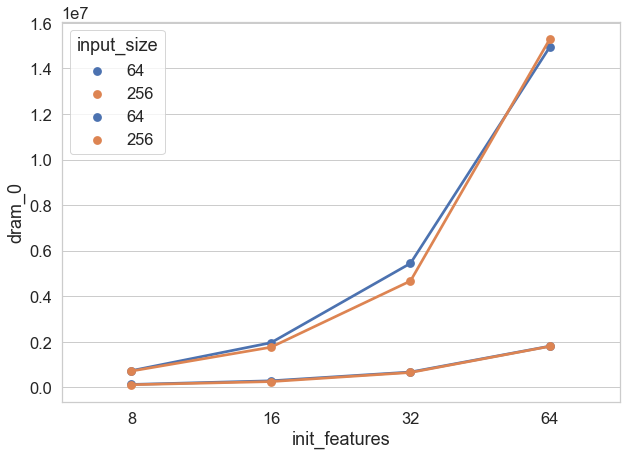

In [28]:
plot_df = joules_df.copy()
sns.set(font_scale = 1.5)
with sns.axes_style("whitegrid"):
    fig, ax1 = plt.subplots(figsize=(10,7),sharex=True,sharey=True)
    
    # fixed input size
    g = sns.pointplot(x='init_features',y='package_0', hue='input_size', data=plot_df,ax=ax1,label='package')
    g = sns.pointplot(x='init_features',y='dram_0', hue='input_size', data=plot_df, ax=ax1, label='dram')
